In [1]:
import scipy.io
import os
import shutil
try:
    from urllib import urlretrieve # python2
except:
    from urllib.request import urlretrieve # python3


In [2]:
import data as data
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch
device = T.device("cuda")  # apply to Tensor or Module
import time
from tqdm import tqdm
from train_objectives import SAD, SID

In [3]:
torch.cuda.empty_cache()

In [4]:
mat = scipy.io.loadmat( 'PaviaU.mat' )
img = mat[ 'paviaU' ]

# create a hyperspectral dataset object from the numpy array
hypData = data.HypImg( img )

# pre-process data to make the model easier to train
hypData.pre_process( 'minmax' )

In [5]:
# create data iterator objects for training and validation using the pre-processed data
trainSamples = 200000
valSamples = 100
dataTrain = data.Iterator( dataSamples=hypData.spectraPrep[:trainSamples, :],
                        targets=hypData.spectraPrep[:trainSamples, :], batchSize=4 )
dataVal = data.Iterator( dataSamples=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :],
                        targets=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :] )


In [6]:
# shuffle training data
dataTrain.shuffle()

In [7]:
train_data = torch.tensor(dataTrain.dataSamples.astype(np.float32))
train_data

tensor([[2.6691e-01, 4.9517e-01, 3.3333e-01,  ..., 7.0411e-01, 7.1981e-01,
         7.3792e-01],
        [5.9870e-02, 3.3788e-02, 4.7424e-03,  ..., 4.0901e-01, 4.1375e-01,
         4.2887e-01],
        [9.0297e-02, 4.9901e-02, 3.9604e-07,  ..., 4.9228e-01, 4.7842e-01,
         4.4753e-01],
        ...,
        [1.9806e-01, 1.2303e-01, 6.7740e-02,  ..., 8.9490e-01, 9.1343e-01,
         9.2497e-01],
        [4.8100e-07, 9.6682e-02, 9.8125e-02,  ..., 6.1087e-01, 6.0029e-01,
         5.9404e-01],
        [3.0615e-01, 2.4106e-01, 1.3740e-01,  ..., 8.9514e-01, 9.0117e-01,
         9.1764e-01]])

In [8]:
hypData.numBands
encoderSize=[50,30,10]
encoderSize=[hypData.numBands]+encoderSize
decodersize=encoderSize[::-1]
encoderSize,decodersize

([103, 50, 30, 10], [10, 30, 50, 103])

In [9]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [10]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enn1 = T.nn.Linear(103, 50)  # 64-16-2-16-64
    self.enn2 = T.nn.Linear(50, 30)
    self.enn3 = T.nn.Linear(30,10)
    self.dnn3 = T.nn.Linear(10, 30)  # 64-16-2-16-64
    self.dnn2 = T.nn.Linear(30, 50)
    self.dnn1 = T.nn.Linear(50,103)

  def encoder(self,x):
    z= T.relu(self.enn1(x))
    z= T.relu(self.enn2(z))
    z= T.relu(self.enn3(z))
    return z
  
  def decoder(self,x):
    z= T.relu(self.dnn3(x))
    z= T.relu(self.dnn2(z))
    z= self.dnn1(z)
    return z


  def forward(self, x):
    encoded=self.encoder(x)
    decoded= self.decoder(encoded)
    
    return encoded,decoded
    
net=Net().to(device)


In [12]:

inpu=torch.rand(1,103).to(device)
outp=net(inpu)
outp[1].shape


torch.Size([1, 103])

In [13]:
hypData.numBands

103

In [14]:
# -----------------------------------------------------------

force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

bat_size = 8184
train_ldr = T.utils.data.DataLoader(train_data,
batch_size=bat_size, shuffle=True)
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 2000
ep_log_interval = 5
lrn_rate = 0.0001

loss_func1 = T.nn.MSELoss()
loss_func = SID()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()


for epoch in range(0, max_epochs):
  time.sleep(0.5)
  loop= tqdm(enumerate(train_ldr), total=len(train_ldr),leave=True)
  epoch_loss = 0  # for one full epoch
  mseloss=0

  iterator = iter(train_ldr)
  
  for (batch_idx, batch) in loop:
    Z = next(iterator)
    Z = Z.view(Z.size()[0], -1)
    Z = Z.cuda()
    
    enc_out, dec_out = net(Z.float())
    loss1 = loss_func(dec_out, Z.float())  
    loss1 = torch.sum(loss1).float()
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    
    X = batch.to(device)  # no targets needed
    
    '''optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt[1], X)  # note: X not Y'''
    #loss_obj1=loss_func1(oupt[1],X)
    epoch_loss += loss1.item()  # accumulate
    #mseloss+=loss_obj1.item()
    #loss_obj.backward()
    #optimizer.step()
    
    loop.set_description(f"Epoch [{epoch}/{max_epochs}]")
    loop.set_postfix(loss=str(epoch_loss))

    

  #if epoch % ep_log_interval == 0:
    
    
    #print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()





KeyboardInterrupt: 

In [14]:
p=net(Z.float())
p.detach()

AttributeError: 'tuple' object has no attribute 'detach'

In [15]:
torch.save(net, 'model_sid_og.pth')

In [16]:
torch.save(net.state_dict(), 'net_model_sid_og.pth')

In [11]:
net.load_state_dict(torch.load('net_model_sid_og.pth'))

<All keys matched successfully>

In [12]:
trex=torch.tensor(hypData.spectraPrep.astype(np.float32))
trex.shape

torch.Size([207400, 103])

In [13]:
dataZ=net.encoder(trex.to("cuda"))
dataZ.shape

torch.Size([207400, 10])

In [18]:
dataY = net.decoder(dataZ)
dataY.shape

tensor([[-0.0104, -0.0086,  0.0014,  ..., -0.0200,  0.0221,  0.0286],
        [-0.0143, -0.0119,  0.0036,  ..., -0.0180,  0.0207,  0.0277],
        [-0.0204, -0.0177,  0.0072,  ..., -0.0157,  0.0174,  0.0269],
        ...,
        [-0.0069, -0.0054,  0.0007,  ..., -0.0207,  0.0250,  0.0288],
        [-0.0121, -0.0098,  0.0029,  ..., -0.0187,  0.0223,  0.0278],
        [-0.0109, -0.0083,  0.0020,  ..., -0.0203,  0.0226,  0.0287]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [19]:
imgZ = np.reshape(dataZ.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [20]:
imgY = np.reshape(dataY.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [21]:
imgX = np.reshape(hypData.spectraPrep, (hypData.numRows, hypData.numCols, -1))

In [22]:
# visualise latent image using 3 out of the 10 dimensions
colourImg = imgZ.copy()
colourImg = colourImg[ :,:,np.argsort(-np.std(np.std(colourImg, axis=0), axis=0))[:3] ]
colourImg /= np.max(np.max(colourImg, axis=0), axis=0)

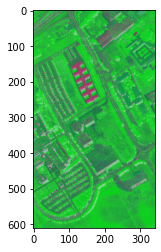

In [23]:
plt.imshow(colourImg)

Text(0.5, 1.0, 'meadow spectra')

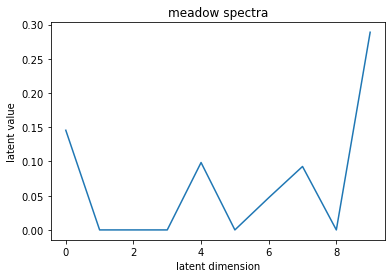

In [24]:
# save plot of latent vector of 'meadow' spectra
fig = plt.figure()
plt.plot(imgZ[576, 210, :])
plt.xlabel('latent dimension')
plt.ylabel('latent value')
plt.title('meadow spectra')

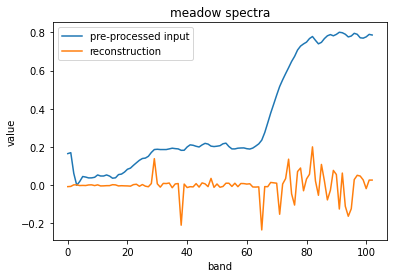

In [25]:
# save plot comparing pre-processed 'meadow' spectra input with decoder reconstruction
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(hypData.numBands),imgX[576, 210, :],label='pre-processed input')
ax.plot(range(hypData.numBands),imgY[576, 210, :],label='reconstruction')
plt.xlabel('band')
plt.ylabel('value')
plt.title('meadow spectra')
ax.legend()

In [26]:
loss_func = SID()
inpt1=torch.rand(3,103)
inpt2=torch.rand(3,103)
outp=loss_func(inpt1,inpt2)
outp

tensor(0.0060)

In [27]:
from math import log10, sqrt
import numpy as np
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def main():
     original = imgX[576, 210, :]
     compressed = imgY[576, 210, :]
     value = PSNR(original, compressed)
     print(f"PSNR value is {value} dB")
       
if __name__ == "__main__":
    main()

PSNR value is 55.190188260329776 dB


In [28]:
psnr=[]
import statistics
for i in range(hypData.numBands):
    original = imgX[:, :, i]
    compressed = imgY[:, :, i]
    value = PSNR(original, compressed)
    psnr.append(value)
    

print(f" Mean PSNR value is {statistics.mean(psnr)} dB")

 Mean PSNR value is 58.2941138817173 dB


In [29]:
from skimage.metrics import structural_similarity
##skimage.metrics.
import argparse
import imutils
import cv2



# 3. Load the two input images
imageA = imgX[:, :, 20]
imageB = imgY[:, :, 20]

# 4. Convert the images to grayscale
#grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
#grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)


# 5. Compute the Structural Similarity Index (SSIM) between the two
#    images, ensuring that the difference image is returned
(score, diff) = structural_similarity(imageA, imageB, full=True)
diff = (diff * 255).astype("uint8")

# 6. You can print only the score if you want
print("SSIM: {}".format(score))



SSIM: 0.007591382022735741


d:\Anaconda\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [30]:
from skimage.metrics import structural_similarity
##skimage.metrics.
import argparse
import imutils
import cv2

ssim_score=[]
import statistics
for i in range(hypData.numBands):
    # 3. Load the two input images
    imageA = imgX[:, :, i]
    imageB = imgY[:, :, i]

    # 4. Convert the images to grayscale
    #grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    #grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)


    # 5. Compute the Structural Similarity Index (SSIM) between the two
    #    images, ensuring that the difference image is returned
    (score, diff) = structural_similarity(imageA, imageB, full=True)
    diff = (diff * 255).astype("uint8")
    ssim_score.append(score)

# 6. You can print only the score if you want
print("SSIM: {}".format(score))
print(f"Mean SSIM {statistics.mean(ssim_score)} dB")




SSIM: 0.025066669210368913
Mean SSIM 0.021173505562461257 dB


In [32]:
input=Z
target=dec_out
eps=1

normalize_inp = (input/torch.sum(input, dim=0)) + eps
normalize_tar = (target/torch.sum(target, dim=0)) + eps
sid = torch.sum(normalize_inp * torch.log(normalize_inp / normalize_tar) + normalize_tar * torch.log(normalize_tar / normalize_inp))
sid

tensor(0.0069, device='cuda:0', grad_fn=<SumBackward0>)

In [33]:
decout = dec_out.detach()
decout.shape

torch.Size([3584, 103])

In [30]:
tensory=dataY.reshape(hypData.numRows, hypData.numCols, -1)
tensorx=torch.Tensor(imgX)

In [31]:
def cross_correlation(H_fuse, H_ref):
    N_spectral = H_fuse.shape[2]

    # Rehsaping fused and reference data
    H_fuse_reshaped = H_fuse.view(N_spectral, -1)
    H_ref_reshaped = H_ref.view(N_spectral, -1)

    # Calculating mean value
    mean_fuse = torch.mean(H_fuse_reshaped, 1).unsqueeze(1)
    mean_ref = torch.mean(H_ref_reshaped, 1).unsqueeze(1)

    CC = torch.sum((H_fuse_reshaped- mean_fuse)*(H_ref_reshaped-mean_ref), 1)/torch.sqrt(torch.sum((H_fuse_reshaped- mean_fuse)**2, 1)*torch.sum((H_ref_reshaped-mean_ref)**2, 1))

    CC = torch.mean(CC)
    return CC
cross_correlation(tensorx.cpu(),tensory.cpu())

tensor(0.0528, grad_fn=<MeanBackward0>)

In [32]:
def SAM(H_fuse, H_ref):
    #Compute number of spectral bands
    N_spectral = H_fuse.shape[2]

    # Rehsaping fused and reference data
    H_fuse_reshaped = H_fuse.view(N_spectral, -1)
    H_ref_reshaped  = H_ref.view(N_spectral, -1)
    N_pixels = H_fuse_reshaped.shape[1]
    
    # Calculating inner product
    inner_prod  = torch.nansum(H_fuse_reshaped*H_ref_reshaped, 0)
    fuse_norm   = torch.nansum(H_fuse_reshaped**2, dim=0).sqrt()
    ref_norm    = torch.nansum(H_ref_reshaped**2, dim=0).sqrt()

    # Calculating SAM
    SAM = torch.rad2deg(torch.nansum( torch.acos(inner_prod/(fuse_norm*ref_norm)) )/N_pixels)
    return SAM
SAM(tensorx.cpu(),tensory.cpu())

tensor(88.6861, grad_fn=<Rad2DegBackward0>)

In [33]:
def RMSE(H_fuse, H_ref):
    # Rehsaping fused and reference data
    H_fuse_reshaped = H_fuse.view(-1)
    H_ref_reshaped = H_ref.view(-1)

    # Calculating RMSE
    RMSE = torch.sqrt(torch.nansum((H_ref_reshaped - H_fuse_reshaped)**2)/H_fuse_reshaped.shape[0])
    return RMSE
RMSE(tensorx.cpu(),tensory.cpu())

tensor(0.4180, grad_fn=<SqrtBackward0>)

In [34]:
# Peak SNR (PSNR)
def PSNR2(H_fuse, H_ref):
    #Compute number of spectral bands
    N_spectral = H_fuse.shape[2]

    # Reshaping images
    H_fuse_reshaped = H_fuse.view(N_spectral, -1)
    H_ref_reshaped = H_ref.view(N_spectral, -1)

    # Calculating RMSE of each band
    rmse = torch.sqrt(torch.sum((H_ref_reshaped-H_fuse_reshaped)**2, dim=1)/H_fuse_reshaped.shape[1])

    # Calculating max of H_ref for each band
    max_H_ref, _ = torch.max(H_ref_reshaped, dim=1)

    # Calculating PSNR
    PSNR = torch.nansum(10*torch.log10(torch.div(max_H_ref, rmse)**2))/N_spectral

    return PSNR
PSNR2(tensorx.cpu(),tensory.cpu()) 

tensor(-5.4324, grad_fn=<DivBackward0>)

In [36]:
tensorx.shape[2]

103